In [53]:
import pandas as pd
import plotly_express as px
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

In [2]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [3]:
df = pd.read_csv("sale.csv",
                 converters={"order_id":str,"product_id":str,"category_id":str,"user_id":str}
                )  
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local
0,2020-04-24 11:50:39 UTC,2294359932054530000,1515966223509080000,2268105426648170000,electronics.tablet,brand_1,162.01,1515915625441990000,24,女,海南
1,2020-04-24 11:50:39 UTC,2294359932054530000,1515966223509080000,2268105426648170000,electronics.tablet,brand_1,162.01,1515915625441990000,24,女,海南
2,2020-04-24 14:37:43 UTC,2294444024058080000,2273948319057180000,2268105430162990000,electronics.audio.headphone,brand_2,77.52,1515915625447870000,38,女,北京
3,2020-04-24 14:37:43 UTC,2294444024058080000,2273948319057180000,2268105430162990000,electronics.audio.headphone,brand_2,77.52,1515915625447870000,38,女,北京
4,2020-04-24 19:16:21 UTC,2294584263154070000,2273948316817420000,2268105471367840000,NaN,brand_3,217.57,1515915625443140000,32,女,广东


In [4]:
df.describe()

,price,age
count,564169.000000,564169.000000
mean,208.269324,33.184388
std,304.559875,10.122088
min,0.000000,16.000000
25%,23.130000,24.000000
50%,87.940000,33.000000
75%,277.750000,42.000000
max,18328.680000,50.000000


In [5]:
df["user_id"].nunique()

6908

数据预处理

In [6]:
df.isnull().sum()

event_time            0
order_id              0
product_id            0
category_id           0
category_code    129370
brand                 0
price                 0
user_id               0
age                   0
sex                   0
local                 0
dtype: int64

<AxesSubplot:>

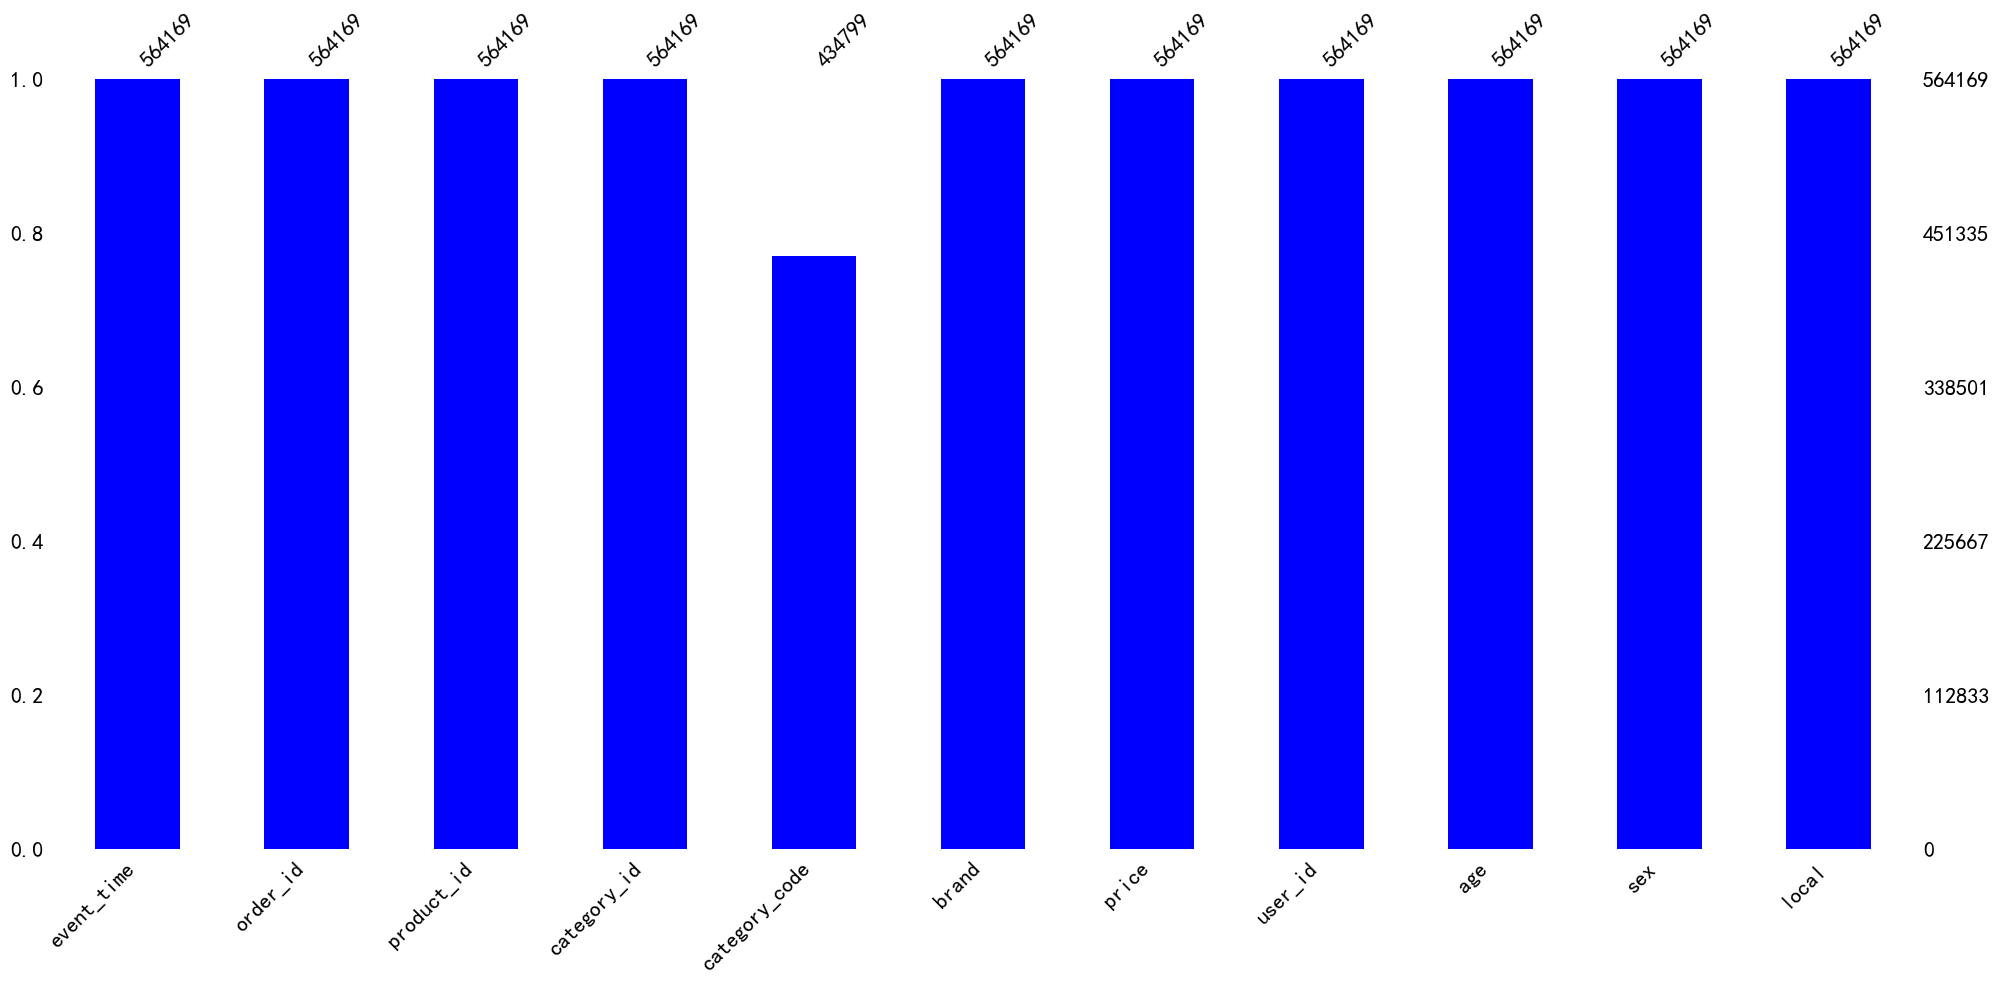

In [7]:
msno.bar(df,labels=True,color="blue")

In [8]:
df.fillna("missing",inplace=True)

In [9]:
df["event_time"] = df["event_time"].apply(lambda x: x[:19])  
df['event_time'] = pd.to_datetime(df['event_time'], format="%Y-%m-%d %H:%M:%S")

In [10]:
df_rfm = df.copy()

In [11]:
df['month']=df['event_time'].dt.month
df['day'] = df['event_time'].dt.day
df['dayofweek']=df['event_time'].dt.dayofweek
df['hour']=df['event_time'].dt.hour

用户特征提取和构建

1.年龄，性别

In [12]:
age_all = df[["user_id","age", "sex"]]
age_all.head()

,user_id,age,sex
0,1515915625441990000,24,女
1,1515915625441990000,24,女
2,1515915625447870000,38,女
3,1515915625447870000,38,女
4,1515915625443140000,32,女


In [13]:
age_all.drop_duplicates("user_id",inplace=True,keep="first")

d:\Anaconda3\envs\ecommerce_project\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [14]:
fig=px.box(age_all[["user_id","age"]],y="age")
fig.show()

In [15]:
fig=px.box(age_all,y="age",color="sex")
fig.show()

2.地域

In [16]:
local = df[["user_id","local"]]
local.drop_duplicates("user_id", inplace=True, keep="first")

d:\Anaconda3\envs\ecommerce_project\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
local.head()

,user_id,local
0,1515915625441990000,海南
2,1515915625447870000,北京
4,1515915625443140000,广东
5,1515915625450380000,重庆
6,1515915625448760000,北京


In [18]:
fig = px.bar(local['local'].value_counts())
fig.show()

3.总订单数量和消费金额

In [19]:
order_count_sale = (df.groupby("user_id")
    .agg(order_number=("order_id","count"), order_amount=("price","sum"))
    .reset_index())

order_count_sale.head()

,user_id,order_number,order_amount
0,1515915625439950000,1,416.64
1,1515915625440030000,2,56.43
2,1515915625440050000,14,7530.34
3,1515915625440090000,24,5074.47
4,1515915625440120000,2,182.83


4.用户平均消费金额

In [20]:
order_count_sale["average"] = order_count_sale["order_amount"] / order_count_sale["order_number"]
order_count_sale.head()

,user_id,order_number,order_amount,average
0,1515915625439950000,1,416.64,416.640000
1,1515915625440030000,2,56.43,28.215000
2,1515915625440050000,14,7530.34,537.881429
3,1515915625440090000,24,5074.47,211.436250
4,1515915625440120000,2,182.83,91.415000


5.用户复购周期（天）

In [21]:
re_buy_day = df[["user_id","event_time"]]
re_buy_day.head()

,user_id,event_time
0,1515915625441990000,2020-04-24 11:50:39
1,1515915625441990000,2020-04-24 11:50:39
2,1515915625447870000,2020-04-24 14:37:43
3,1515915625447870000,2020-04-24 14:37:43
4,1515915625443140000,2020-04-24 19:16:21


In [22]:
re_buy_day["event_time"].value_counts().sort_values(ascending=False)

1970-01-01 00:33:40    1307
2020-04-09 16:30:01      51
2020-04-08 16:30:01      49
2020-11-19 14:01:56      47
2020-04-06 16:30:01      46
                       ... 
2020-05-10 15:50:19       1
2020-05-10 15:53:34       1
2020-05-10 15:54:57       1
2020-05-10 15:58:00       1
2020-09-05 08:16:30       1
Name: event_time, Length: 389835, dtype: int64

In [23]:
re_buy_day.shape

(564169, 2)

In [24]:
re_buy_day = re_buy_day[re_buy_day["event_time"] != "1970-01-01 00:33:40"]

In [25]:
re_buy_day.shape

(562862, 2)

In [26]:
re_buy_day.drop_duplicates(inplace=True,ignore_index=True)

In [27]:
re_buy_day = re_buy_day.sort_values(["user_id","event_time"],ignore_index=True)
re_buy_day.head()

,user_id,event_time
0,1515915625439950000,2020-07-09 06:35:18
1,1515915625440030000,2020-09-22 15:11:15
2,1515915625440030000,2020-10-28 05:53:47
3,1515915625440050000,2020-10-21 12:23:18
4,1515915625440050000,2020-10-23 03:51:26


In [28]:
re_buy_day_2 = re_buy_day.groupby("user_id").apply(lambda x:x.shift())
re_buy_day_2.columns = ["user_id","event_time_shift"]
re_buy_day_2

,user_id,event_time_shift
0,NaN,NaT
1,NaN,NaT
2,1515915625440030000,2020-09-22 15:11:15
3,NaN,NaT
4,1515915625440050000,2020-10-21 12:23:18
...,...,...
397556,1515915625514880000,2020-11-21 09:28:12
397557,1515915625514880000,2020-11-21 09:34:29
397558,1515915625514880000,2020-11-21 09:50:11
397559,NaN,NaT


In [29]:
re_buy_day["event_time_shift"] = re_buy_day_2["event_time_shift"]
re_buy_day

,user_id,event_time,event_time_shift
0,1515915625439950000,2020-07-09 06:35:18,NaT
1,1515915625440030000,2020-09-22 15:11:15,NaT
2,1515915625440030000,2020-10-28 05:53:47,2020-09-22 15:11:15
3,1515915625440050000,2020-10-21 12:23:18,NaT
4,1515915625440050000,2020-10-23 03:51:26,2020-10-21 12:23:18
...,...,...,...
397556,1515915625514880000,2020-11-21 09:34:29,2020-11-21 09:28:12
397557,1515915625514880000,2020-11-21 09:50:11,2020-11-21 09:34:29
397558,1515915625514880000,2020-11-21 10:10:01,2020-11-21 09:50:11
397559,1515915625514890000,2020-11-21 10:04:42,NaT


In [30]:
re_buy_day_3 = re_buy_day.dropna().reset_index()
re_buy_day_3

,index,user_id,event_time,event_time_shift
0,2,1515915625440030000,2020-10-28 05:53:47,2020-09-22 15:11:15
1,4,1515915625440050000,2020-10-23 03:51:26,2020-10-21 12:23:18
2,5,1515915625440050000,2020-10-23 06:38:11,2020-10-23 03:51:26
3,6,1515915625440050000,2020-10-23 07:02:33,2020-10-23 06:38:11
4,7,1515915625440050000,2020-11-16 15:49:50,2020-10-23 07:02:33
...,...,...,...,...
390648,397555,1515915625514880000,2020-11-21 09:28:12,2020-11-21 09:18:31
390649,397556,1515915625514880000,2020-11-21 09:34:29,2020-11-21 09:28:12
390650,397557,1515915625514880000,2020-11-21 09:50:11,2020-11-21 09:34:29
390651,397558,1515915625514880000,2020-11-21 10:10:01,2020-11-21 09:50:11


In [31]:
re_buy_day_3["time_gap"] = re_buy_day_3["event_time"] - re_buy_day_3["event_time_shift"]
re_buy_day_3

,index,user_id,event_time,event_time_shift,time_gap
0,2,1515915625440030000,2020-10-28 05:53:47,2020-09-22 15:11:15,35 days 14:42:32
1,4,1515915625440050000,2020-10-23 03:51:26,2020-10-21 12:23:18,1 days 15:28:08
2,5,1515915625440050000,2020-10-23 06:38:11,2020-10-23 03:51:26,0 days 02:46:45
3,6,1515915625440050000,2020-10-23 07:02:33,2020-10-23 06:38:11,0 days 00:24:22
4,7,1515915625440050000,2020-11-16 15:49:50,2020-10-23 07:02:33,24 days 08:47:17
...,...,...,...,...,...
390648,397555,1515915625514880000,2020-11-21 09:28:12,2020-11-21 09:18:31,0 days 00:09:41
390649,397556,1515915625514880000,2020-11-21 09:34:29,2020-11-21 09:28:12,0 days 00:06:17
390650,397557,1515915625514880000,2020-11-21 09:50:11,2020-11-21 09:34:29,0 days 00:15:42
390651,397558,1515915625514880000,2020-11-21 10:10:01,2020-11-21 09:50:11,0 days 00:19:50


In [32]:
re_buy_day_3["day_gap"] = re_buy_day_3["time_gap"].dt.days
re_buy_day_3

,index,user_id,event_time,event_time_shift,time_gap,day_gap
0,2,1515915625440030000,2020-10-28 05:53:47,2020-09-22 15:11:15,35 days 14:42:32,35
1,4,1515915625440050000,2020-10-23 03:51:26,2020-10-21 12:23:18,1 days 15:28:08,1
2,5,1515915625440050000,2020-10-23 06:38:11,2020-10-23 03:51:26,0 days 02:46:45,0
3,6,1515915625440050000,2020-10-23 07:02:33,2020-10-23 06:38:11,0 days 00:24:22,0
4,7,1515915625440050000,2020-11-16 15:49:50,2020-10-23 07:02:33,24 days 08:47:17,24
...,...,...,...,...,...,...
390648,397555,1515915625514880000,2020-11-21 09:28:12,2020-11-21 09:18:31,0 days 00:09:41,0
390649,397556,1515915625514880000,2020-11-21 09:34:29,2020-11-21 09:28:12,0 days 00:06:17,0
390650,397557,1515915625514880000,2020-11-21 09:50:11,2020-11-21 09:34:29,0 days 00:15:42,0
390651,397558,1515915625514880000,2020-11-21 10:10:01,2020-11-21 09:50:11,0 days 00:19:50,0


In [33]:
re_buy_day_4 = (re_buy_day_3.groupby("user_id")
       .agg(days=("day_gap","sum"), repurchase_times=("day_gap","count"))
       .reset_index()
      )
re_buy_day_4

,user_id,days,repurchase_times
0,1515915625440030000,35,1
1,1515915625440050000,25,4
2,1515915625440090000,174,18
3,1515915625440120000,58,1
4,1515915625440880000,166,35
...,...,...,...
6720,1515915625514850000,60,16
6721,1515915625514860000,0,10
6722,1515915625514870000,0,26
6723,1515915625514880000,0,15


In [34]:
re_buy_day_4["average_repurchase"] = re_buy_day_4["days"] / re_buy_day_4["repurchase_times"]
re_buy_day_4

,user_id,days,repurchase_times,average_repurchase
0,1515915625440030000,35,1,35.000000
1,1515915625440050000,25,4,6.250000
2,1515915625440090000,174,18,9.666667
3,1515915625440120000,58,1,58.000000
4,1515915625440880000,166,35,4.742857
...,...,...,...,...
6720,1515915625514850000,60,16,3.750000
6721,1515915625514860000,0,10,0.000000
6722,1515915625514870000,0,26,0.000000
6723,1515915625514880000,0,15,0.000000


In [35]:
re_buy_day_4.describe()

,days,repurchase_times,average_repurchase
count,6725.000000,6725.000000,6725.000000
mean,153.678662,58.089665,6.870399
std,88.071700,258.018118,8.364357
min,0.000000,1.000000,0.000000
25%,81.000000,16.000000,2.414414
50%,149.000000,30.000000,5.020833
75%,238.000000,48.000000,8.352941
max,316.000000,7936.000000,139.000000


上面的字段含义：

- days：表示每位用户不同复购间隔天数的**总和**
- repurchase_times：表示**复购次数**
- average_repurchase：表示**平均复购周期**

6.整体用户特征

In [36]:
all_label = age_all.copy()

In [37]:
for df in [local,order_count_sale,re_buy_day_4]:
    all_label = pd.merge(all_label,df,how="outer")

In [38]:
all_label

,user_id,age,sex,local,order_number,order_amount,average,days,repurchase_times,average_repurchase
0,1515915625441990000,24,女,海南,68,14928.30,219.533824,274.0,56.0,4.892857
1,1515915625447870000,38,女,北京,59,20852.56,353.433220,186.0,47.0,3.957447
2,1515915625443140000,32,女,广东,112,21804.38,194.681964,269.0,79.0,3.405063
3,1515915625450380000,20,男,重庆,65,24647.43,379.191231,242.0,49.0,4.938776
4,1515915625448760000,21,男,北京,49,17162.03,350.245510,254.0,34.0,7.470588
...,...,...,...,...,...,...,...,...,...,...
6903,1515915625514850000,38,男,重庆,21,6241.64,297.220952,60.0,16.0,3.750000
6904,1515915625514860000,48,男,湖南,12,3572.18,297.681667,0.0,10.0,0.000000
6905,1515915625514870000,49,男,北京,29,7375.92,254.342069,0.0,26.0,0.000000
6906,1515915625514880000,20,男,浙江,16,8770.02,548.126250,0.0,15.0,0.000000


In [39]:
all_label.dtypes

user_id                object
age                     int64
sex                    object
local                  object
order_number            int64
order_amount          float64
average               float64
days                  float64
repurchase_times      float64
average_repurchase    float64
dtype: object

In [40]:
all_label.isnull().sum()

user_id                 0
age                     0
sex                     0
local                   0
order_number            0
order_amount            0
average                 0
days                  183
repurchase_times      183
average_repurchase    183
dtype: int64

In [41]:
all_label.fillna(0,inplace=True)

In [42]:
all_label.isnull().sum()

user_id               0
age                   0
sex                   0
local                 0
order_number          0
order_amount          0
average               0
days                  0
repurchase_times      0
average_repurchase    0
dtype: int64

特征工程

In [43]:
all_label["sex"] = all_label["sex"].map({"男":0, "女":1})

In [44]:
local_encode = LabelEncoder()

In [45]:
all_label["local"] = local_encode.fit_transform(all_label["local"])
all_label

,user_id,age,sex,local,order_number,order_amount,average,days,repurchase_times,average_repurchase
0,1515915625441990000,24,1,7,68,14928.30,219.533824,274.0,56.0,4.892857
1,1515915625447870000,38,1,1,59,20852.56,353.433220,186.0,47.0,3.957447
2,1515915625443140000,32,1,4,112,21804.38,194.681964,269.0,79.0,3.405063
3,1515915625450380000,20,0,10,65,24647.43,379.191231,242.0,49.0,4.938776
4,1515915625448760000,21,0,1,49,17162.03,350.245510,254.0,34.0,7.470588
...,...,...,...,...,...,...,...,...,...,...
6903,1515915625514850000,38,0,10,21,6241.64,297.220952,60.0,16.0,3.750000
6904,1515915625514860000,48,0,9,12,3572.18,297.681667,0.0,10.0,0.000000
6905,1515915625514870000,49,0,1,29,7375.92,254.342069,0.0,26.0,0.000000
6906,1515915625514880000,20,0,6,16,8770.02,548.126250,0.0,15.0,0.000000


In [47]:
user_id = all_label["user_id"]
user_id

0       1515915625441990000
1       1515915625447870000
2       1515915625443140000
3       1515915625450380000
4       1515915625448760000
               ...         
6903    1515915625514850000
6904    1515915625514860000
6905    1515915625514870000
6906    1515915625514880000
6907    1515915625514890000
Name: user_id, Length: 6908, dtype: object

In [49]:
all_label_without_userid = all_label.drop("user_id",axis=1)
all_label_without_userid

,age,sex,local,order_number,order_amount,average,days,repurchase_times,average_repurchase
0,24,1,7,68,14928.30,219.533824,274.0,56.0,4.892857
1,38,1,1,59,20852.56,353.433220,186.0,47.0,3.957447
2,32,1,4,112,21804.38,194.681964,269.0,79.0,3.405063
3,20,0,10,65,24647.43,379.191231,242.0,49.0,4.938776
4,21,0,1,49,17162.03,350.245510,254.0,34.0,7.470588
...,...,...,...,...,...,...,...,...,...
6903,38,0,10,21,6241.64,297.220952,60.0,16.0,3.750000
6904,48,0,9,12,3572.18,297.681667,0.0,10.0,0.000000
6905,49,0,1,29,7375.92,254.342069,0.0,26.0,0.000000
6906,20,0,6,16,8770.02,548.126250,0.0,15.0,0.000000


In [51]:
corr = all_label_without_userid.corr()
corr

,age,sex,local,order_number,order_amount,average,days,repurchase_times,average_repurchase
age,1.000000,0.008126,-0.010255,-0.002118,-0.003759,0.002222,0.010108,-0.001833,0.004953
sex,0.008126,1.000000,0.022428,-0.010818,-0.010399,-0.002653,-0.010587,-0.011022,-0.006073
local,-0.010255,0.022428,1.000000,0.007348,0.003766,0.004585,-0.006894,0.007245,-0.007852
order_number,-0.002118,-0.010818,0.007348,1.000000,0.982831,-0.075352,-0.021935,0.998314,-0.100692
order_amount,-0.003759,-0.010399,0.003766,0.982831,1.000000,-0.023216,-0.024667,0.984607,-0.137787
average,0.002222,-0.002653,0.004585,-0.075352,-0.023216,1.000000,-0.252446,-0.070670,-0.101955
days,0.010108,-0.010587,-0.006894,-0.021935,-0.024667,-0.252446,1.000000,-0.020611,0.216346
repurchase_times,-0.001833,-0.011022,0.007245,0.998314,0.984607,-0.070670,-0.020611,1.000000,-0.107803
average_repurchase,0.004953,-0.006073,-0.007852,-0.100692,-0.137787,-0.101955,0.216346,-0.107803,1.000000


Text(0.5, 1.0, 'Features Correlation about Users')

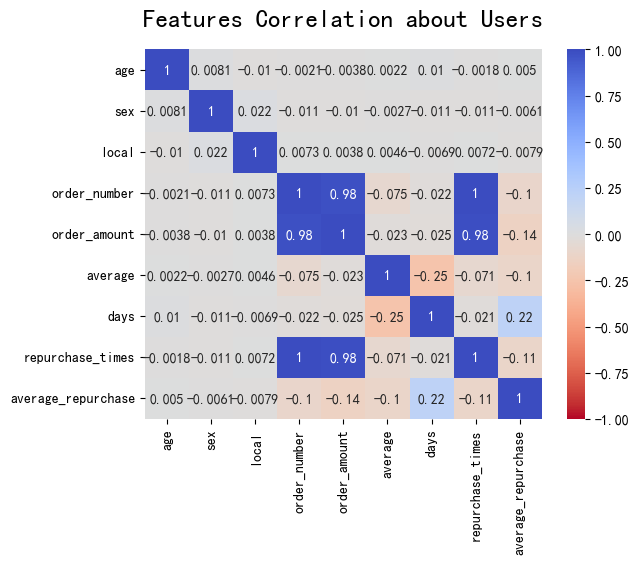

In [52]:
heatmap = sns.heatmap(corr,
                     vmin=-1,
                     vmax=1,
                     annot=True,
                     cmap="coolwarm_r")
heatmap.set_title("Features Correlation about Users",
                  fontdict={"fontsize":18},
                  pad=16)

1. order_amount和order_number：用户订单金额和订单数量；很明显，订单越多，金额越大；
2. order_number和repurchase_times：用户的订单数量越多，存在复购的次数也越多，合理解释；
3. order_amount和repurchase_times：用户的订单金额越大，存在复购的次数也越多，合理解释；

仅保留order_number

In [54]:
all_label_without_userid.drop(["order_amount","repurchase_times"],axis=1,inplace=True)
all_label_without_userid.head()

,age,sex,local,order_number,average,days,average_repurchase
0,24,1,7,68,219.533824,274.0,4.892857
1,38,1,1,59,353.433220,186.0,3.957447
2,32,1,4,112,194.681964,269.0,3.405063
3,20,0,10,65,379.191231,242.0,4.938776
4,21,0,1,49,350.245510,254.0,7.470588


Text(0.5, 1.0, 'Features Correlation about Users')

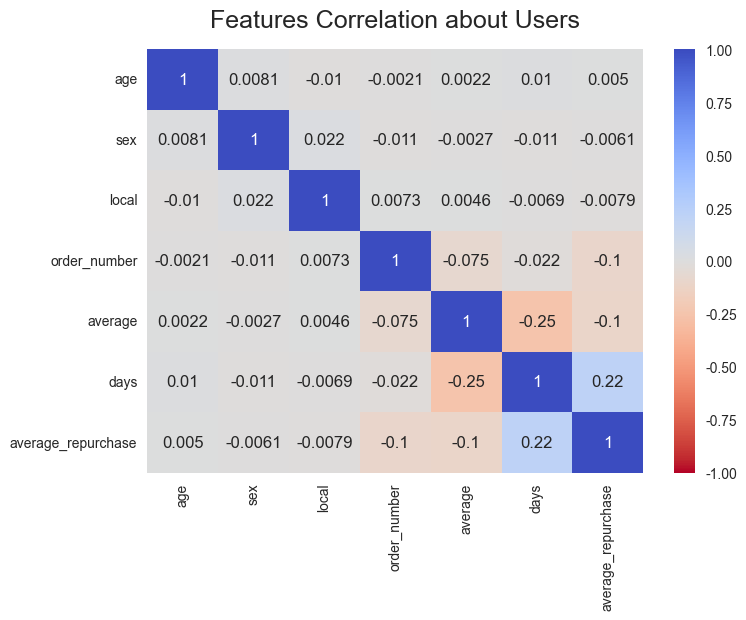

In [55]:
heatmap = sns.heatmap(all_label_without_userid.corr(),
                     vmin=-1,
                     vmax=1,
                     annot=True,
                     cmap="coolwarm_r")
heatmap.set_title("Features Correlation about Users",
                  fontdict={"fontsize":18},
                  pad=16)

聚类建模

In [56]:
mm = MinMaxScaler()

In [57]:
stad_data = mm.fit_transform(all_label_without_userid)
stad_data

array([[0.23529412, 1.        , 0.7       , ..., 0.12529924, 0.86708861,
        0.03520041],
       [0.64705882, 1.        , 0.1       , ..., 0.2025281 , 0.58860759,
        0.02847084],
       [0.47058824, 1.        , 0.4       , ..., 0.11096549, 0.85126582,
        0.02449686],
       ...,
       [0.97058824, 0.        , 0.1       , ..., 0.14537552, 0.        ,
        0.        ],
       [0.11764706, 0.        , 0.6       , ..., 0.31482077, 0.        ,
        0.        ],
       [0.32352941, 1.        , 0.        , ..., 0.38644884, 0.        ,
        0.        ]])

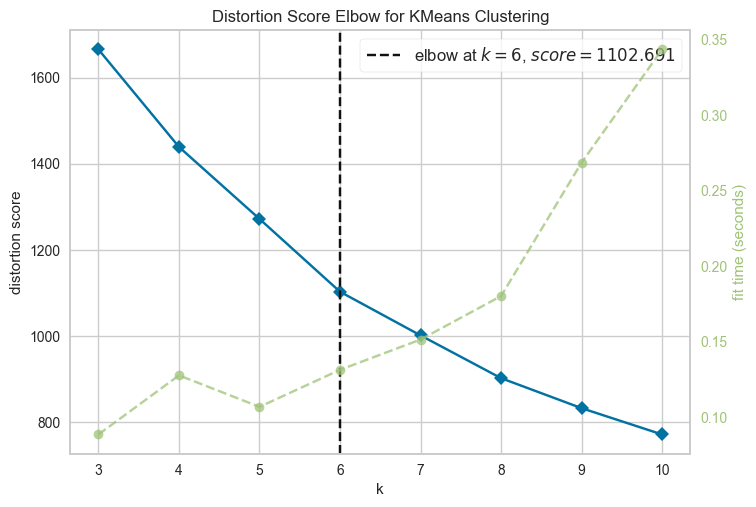

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
visualizer = KElbowVisualizer(KMeans(),k=(3,11))
visualizer.fit(stad_data)
visualizer.poof()

In [59]:
algorithm = (KMeans(n_clusters=6,  # 根据上面的肘图，可以确定K=6
                       init="k-means++",
                       n_init=10,
                       max_iter=300,
                       tol=0.0001,
                       random_state=111,
                       algorithm="elkan"))
algorithm.fit(all_label_without_userid)  

KMeans(algorithm='elkan', n_clusters=6, random_state=111)

In [63]:
labels1=algorithm.labels_
labels1

array([0, 0, 0, ..., 2, 5, 5])

In [64]:
centroids1=algorithm.cluster_centers_
centroids1

array([[3.32566248e+01, 5.09065551e-01, 3.85355649e+00, 6.50547420e+01,
        2.14035671e+02, 2.39952580e+02, 7.94579384e+00],
       [3.29000000e+01, 4.00000000e-01, 4.90000000e+00, 8.17410000e+03,
        1.38958738e+02, 6.87000000e+01, 1.42426323e-02],
       [3.29523810e+01, 5.13532032e-01, 3.86399452e+00, 4.24134978e+01,
        2.21415486e+02, 8.65364851e+01, 5.85681390e+00],
       [3.23023256e+01, 4.18604651e-01, 3.53488372e+00, 1.35553488e+03,
        1.68962237e+02, 1.07023256e+02, 1.44994395e-01],
       [3.17222222e+01, 5.55555556e-01, 3.50000000e+00, 4.24355556e+03,
        1.39796526e+02, 9.78888889e+01, 3.70812113e-02],
       [3.27514286e+01, 5.06666667e-01, 3.93047619e+00, 3.55942857e+01,
        4.70720421e+02, 8.15752381e+01, 6.01124885e+00]])

聚类结果还原

In [66]:
all_label_without_userid["label"]=["Label_" + str(i + 1) for i in labels1]
all_label_without_userid

,age,sex,local,order_number,average,days,average_repurchase,label
0,24,1,7,68,219.533824,274.0,4.892857,Label_1
1,38,1,1,59,353.433220,186.0,3.957447,Label_1
2,32,1,4,112,194.681964,269.0,3.405063,Label_1
3,20,0,10,65,379.191231,242.0,4.938776,Label_1
4,21,0,1,49,350.245510,254.0,7.470588,Label_1
...,...,...,...,...,...,...,...,...
6903,38,0,10,21,297.220952,60.0,3.750000,Label_3
6904,48,0,9,12,297.681667,0.0,0.000000,Label_3
6905,49,0,1,29,254.342069,0.0,0.000000,Label_3
6906,20,0,6,16,548.126250,0.0,0.000000,Label_6


In [67]:
all_label_without_userid["label"].value_counts()

Label_3    2920
Label_1    2871
Label_6    1046
Label_4      43
Label_5      18
Label_2      10
Name: label, dtype: int64

聚类结果3D可视化

In [68]:
fig = px.scatter_3d(all_label_without_userid,
                    x="age",
                    y="local",
                    z="average",
                    color="label"
                   )

fig.show()

In [69]:
fig = px.scatter_3d(all_label_without_userid,
                    x="local",
                    y="days",
                    z="average_repurchase",
                    color="label"
                   )

fig.show()

In [70]:
fig = px.scatter_3d(all_label_without_userid,
                    x="local",
                    y="order_number",
                    z="average_repurchase",
                    color="label"
                   )

fig.show()

In [71]:
fig = px.scatter_3d(all_label_without_userid,
                    x="days",
                    y="order_number",
                    z="average_repurchase",
                    color="label"
                   )

fig.show()

In [72]:
fig = px.scatter_3d(all_label_without_userid,
                    x="days",
                    y="average",
                    z="average_repurchase",
                    color="label"
                   )

fig.show()

In [73]:
fig = px.scatter_3d(all_label_without_userid,
                    x="order_number",
                    y="average",
                    z="average_repurchase",
                    color="label"
                   )

fig.show()

基于RFM分层

In [74]:
df_rfm.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local
0,2020-04-24 11:50:39,2294359932054530000,1515966223509080000,2268105426648170000,electronics.tablet,brand_1,162.01,1515915625441990000,24,女,海南
1,2020-04-24 11:50:39,2294359932054530000,1515966223509080000,2268105426648170000,electronics.tablet,brand_1,162.01,1515915625441990000,24,女,海南
2,2020-04-24 14:37:43,2294444024058080000,2273948319057180000,2268105430162990000,electronics.audio.headphone,brand_2,77.52,1515915625447870000,38,女,北京
3,2020-04-24 14:37:43,2294444024058080000,2273948319057180000,2268105430162990000,electronics.audio.headphone,brand_2,77.52,1515915625447870000,38,女,北京
4,2020-04-24 19:16:21,2294584263154070000,2273948316817420000,2268105471367840000,missing,brand_3,217.57,1515915625443140000,32,女,广东


In [76]:
fm_df = (df_rfm.groupby("user_id")
    .agg(F=("order_id","count"), M=("price","sum"))  # 订单的次数 + 总金额
    .reset_index())
fm_df

,user_id,F,M
0,1515915625439950000,1,416.64
1,1515915625440030000,2,56.43
2,1515915625440050000,14,7530.34
3,1515915625440090000,24,5074.47
4,1515915625440120000,2,182.83
...,...,...,...
6903,1515915625514850000,21,6241.64
6904,1515915625514860000,12,3572.18
6905,1515915625514870000,29,7375.92
6906,1515915625514880000,16,8770.02


In [77]:
df_rfm = df_rfm[df_rfm["event_time"] != "1970-01-01 00:33:40"]

In [78]:
df_rfm['event_time'].value_counts().sort_index()

2020-01-05 04:01:46    1
2020-01-05 04:06:18    1
2020-01-05 04:09:00    1
2020-01-05 04:23:37    1
2020-01-05 04:35:21    1
                      ..
2020-11-21 10:08:14    1
2020-11-21 10:08:54    2
2020-11-21 10:10:01    1
2020-11-21 10:10:13    1
2020-11-21 10:10:30    3
Name: event_time, Length: 389834, dtype: int64

计算R

In [79]:
df_rfm_sorted = df_rfm.sort_values(["user_id","event_time"],ascending=[False, True])
df_rfm_sorted.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local
564158,2020-11-21 10:04:42,2388440981134690000,1515966223509080000,2268105428166500000,electronics.smartphone,brand_5,925.67,1515915625514890000,27,女,上海
564165,2020-11-21 10:10:13,2388440981134690000,1515966223509080000,2268105428166500000,electronics.smartphone,brand_5,418.96,1515915625514890000,21,女,北京
564046,2020-11-21 07:35:58,2388440981134690000,1515966223509100000,2268105409225030000,computers.peripherals.monitor,brand_307,506.92,1515915625514880000,20,男,浙江
564076,2020-11-21 08:16:34,2388440981134690000,1515966223509080000,2268105428166500000,electronics.smartphone,brand_1,115.72,1515915625514880000,37,男,重庆
564082,2020-11-21 08:21:15,2388440981134690000,2388434452476150000,2268105428074230000,electronics.telephone,brand_846,25.44,1515915625514880000,36,男,广东


In [80]:
df_rfm_sorted.drop_duplicates("user_id",keep="first",ignore_index=True,inplace=True)

In [81]:
df_rfm_sorted.shape

(6908, 11)

In [82]:
df_rfm_sorted.dtypes

event_time       datetime64[ns]
order_id                 object
product_id               object
category_id              object
category_code            object
brand                    object
price                   float64
user_id                  object
age                       int64
sex                      object
local                    object
dtype: object

In [83]:
now = pd.to_datetime(datetime.now())

df_rfm_sorted["R"] = now - df_rfm_sorted["event_time"]
df_rfm_sorted["R"]

0       876 days 12:12:48.506857
1       876 days 14:41:32.506857
2       876 days 16:15:09.506857
3       876 days 19:26:09.506857
4       939 days 21:44:25.506857
                  ...           
6903   1065 days 06:08:17.506857
6904   1069 days 16:20:47.506857
6905    907 days 09:54:12.506857
6906    936 days 07:06:15.506857
6907   1011 days 15:42:12.506857
Name: R, Length: 6908, dtype: timedelta64[ns]

In [84]:
df_rfm_sorted["R"] = df_rfm_sorted["R"].apply(lambda x:x.days) 
df_rfm_sorted.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,R
0,2020-11-21 10:04:42,2388440981134690000,1515966223509080000,2268105428166500000,electronics.smartphone,brand_5,925.67,1515915625514890000,27,女,上海,876
1,2020-11-21 07:35:58,2388440981134690000,1515966223509100000,2268105409225030000,computers.peripherals.monitor,brand_307,506.92,1515915625514880000,20,男,浙江,876
2,2020-11-21 06:02:21,2388440981134690000,2273948319141060000,2268105404485460000,medicine.tools.tonometer,brand_9,48.59,1515915625514870000,49,男,北京,876
3,2020-11-21 02:51:21,2388440981134690000,1515966223509100000,2374498914000590000,electronics.video.tv,brand_17,115.72,1515915625514860000,48,男,湖南,876
4,2020-09-19 00:33:05,2388440981134690000,2388434452474160000,2268105458457770000,apparel.glove,brand_31,694.42,1515915625514850000,17,女,四川,939


In [85]:
r_df = df_rfm_sorted[["user_id","R"]]
r_df

,user_id,R
0,1515915625514890000,876
1,1515915625514880000,876
2,1515915625514870000,876
3,1515915625514860000,876
4,1515915625514850000,939
...,...,...
6903,1515915625440120000,1065
6904,1515915625440090000,1069
6905,1515915625440050000,907
6906,1515915625440030000,936


In [86]:
rfm = pd.merge(fm_df,r_df)
rfm

,user_id,F,M,R
0,1515915625439950000,1,416.64,1011
1,1515915625440030000,2,56.43,936
2,1515915625440050000,14,7530.34,907
3,1515915625440090000,24,5074.47,1069
4,1515915625440120000,2,182.83,1065
...,...,...,...,...
6903,1515915625514850000,21,6241.64,939
6904,1515915625514860000,12,3572.18,876
6905,1515915625514870000,29,7375.92,876
6906,1515915625514880000,16,8770.02,876


In [87]:
rfm =  rfm[["R","F","M"]]

In [90]:
rfm.describe()

,R,F,M
count,6908.000000,6908.000000,6.908000e+03
mean,1071.708888,81.668935,1.700913e+04
std,83.033157,401.049395,5.683688e+04
min,876.000000,1.000000,2.290000e+00
25%,999.000000,21.000000,4.736420e+03
50%,1062.000000,40.000000,9.233765e+03
75%,1157.000000,65.000000,1.614614e+04
max,1197.000000,12237.000000,1.588097e+06


In [94]:
r_mean = rfm["R"].mean()
f_mean = rfm["F"].mean()
m_mean = rfm["M"].mean()

r_mean,f_mean,m_mean

(1071.7088882455125, 81.6689345686161, 17009.133815865665)

In [101]:
label = []

In [102]:
for i in range(len(rfm)):
    r,f,m=rfm.iloc[i]
    if r >= r_mean:
        if f >= f_mean:
            if m >= m_mean:
                label.append("重要价值客户")
            else:
                label.append("一般价值客户")
        elif m >= m_mean:
            label.append("重要发展客户")
        else:
            label.append("一般发展客户")
    elif f >= f_mean:
        if m >= m_mean:
            label.append("重要保持客户")
        else:
            label.append("一般保持客户")
    elif m >= m_mean:
        label.append("重要挽留客户")
    else:
        label.append("一般挽留客户")


In [103]:
rfm["label"]=label
rfm

,R,F,M,label
0,1011,1,416.64,一般挽留客户
1,936,2,56.43,一般挽留客户
2,907,14,7530.34,一般挽留客户
3,1069,24,5074.47,一般挽留客户
4,1065,2,182.83,一般挽留客户
...,...,...,...,...
6903,939,21,6241.64,一般挽留客户
6904,876,12,3572.18,一般挽留客户
6905,876,29,7375.92,一般挽留客户
6906,876,16,8770.02,一般挽留客户


In [104]:
rfm["label"].value_counts()

一般挽留客户    2889
一般发展客户    2308
重要价值客户     532
重要保持客户     506
重要挽留客户     317
重要发展客户     239
一般价值客户      96
一般保持客户      21
Name: label, dtype: int64

In [106]:
fig = px.scatter_3d(rfm,
                    x="R",
                    y="F",
                    z="M",
                    color="label"
                   )

fig.show()